# Bloqade python demonstration

It is simple to install bloqade using pip https://pypi.org/project/bloqade/ via `pip install bloqade`. Documentation for bloqade is provided here https://bloqade.quera.com/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import bloqade

One can construct programs using a builder pattern. This pattern means that you can chain together commands to create a complete program.

Let us demonstrate this functionality by implementing the "hello world" of analog Hamiltonian simulation: Rabi oscillations. Aquila's neutral atom hardware requires 4 time dependent fields: position of atoms; Rabi frequency as a function of time; Rabi frequency phase as a function of time; Detuning as a function of time.

In [4]:
#Start by specifying an atom position in 2d space. Units are in micrometers
program = bloqade.start.add_position( (0,0) )

#Next, define the Rabi frequency as a piecewise linear function
program = program.rydberg.rabi.amplitude.uniform.piecewise_linear(
    durations=[0.06,0.06,0.06], values=[0,13.09,13.09,0])

#Next, define the detuning, which we choose to be constant of 0
program = program.detuning.uniform.constant( duration=0.18, value = 0.0 )

# Phase, if unspecified, is implied to be a constant through evolution.
#program = program.rydberg.rabi.phase.uniform.constant( duration=[0.22], value=0.0 )

In [5]:
# This specification can be chained together in a single command
program = bloqade.start.add_position( (0,0) )\
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=[0.06,0.06,0.06], values=[0,13.09,13.09,0])\
    .detuning.uniform.constant(
        duration=0.18, value = 0.0 )\
    .rydberg.rabi.phase.uniform.constant(
        duration=0.18, value=0.0 )

Given a specific program instance, one may run it through emulation or submit through Aquila. Lets do both!

## Emulate
First, let us emulate this evolution using Braket's local emulator

In [6]:
braket_emulated = program.braket.local_emulator()
results = braket_emulated.run(1000).report()

bitstrings = results.bitstrings()

The protocol was designed to implement a $\pi/2$ protocol preparing the Y superposition state $(|0\rangle + i|1\rangle)/\sqrt{2}$. It should give us a 50% chance of measuring ground or excited state. Is this true?

In [7]:
print(results.counts)

[OrderedDict([('1', 508), ('0', 492)])]


## Submit to Aquila
Submission to Aquila is also simple. First, find your AWS credentials through your dashboard

In [8]:
%set_env AWS_DEFAULT_REGION=us-east-1
%set_env AWS_ACCESS_KEY_ID=XX
%set_env AWS_SECRET_ACCESS_KEY=XXX
%set_env AWS_SESSION_TOKEN=XXXX

env: AWS_DEFAULT_REGION=us-east-1
env: AWS_ACCESS_KEY_ID=XX
env: AWS_SECRET_ACCESS_KEY=XXX
env: AWS_SESSION_TOKEN=XXXX


Next, submit the job through Aquila. One of the very handy functionalities is to serialize results and runs to and from file. For this demo, let us load a previously run set of data from file.

In [9]:
ITS_DEMO_TIME = False
filename = "single_run_demo.json"

if ITS_DEMO_TIME==True:
    aquila     = program.braket.aquila()
    aquila_run = aquila.run(100) # This command is blocking, and will not continue until the job is complete.
    # !!! If the queue is full or Aquila's operating window is not open, this will block for a long time.
    bloqade.save_batch(aquila_run,filename)
else:
    aquila_run = bloqade.load_batch(filename)
    
results_aquila    = aquila_run.report()
bitstrings_aquila = results.bitstrings()

FileNotFoundError: [Errno 2] No such file or directory: 'single_run_demo.json'

Are these results consistent with being in the Y superposition state? Lets see!

In [11]:
print(results_aquila.counts)
results_aquila.show()

[OrderedDict([('1', 508), ('0', 492)])]


NameError: name 'results_aquila' is not defined

# And so much more...

Beyond this very basic functionality, bloqade adds extra flexibility at the convenience of the user. Let us implement **blockaded Rabi oscillations** on two atoms in this expanded example, which is a simple demonstration of how easy it is to generate entanglement.

## Feature: Unassigned programs
Instead of generating programs with explicit values, one can instead include variables which can be set later

In [12]:
program = bloqade.start.add_positions( [(0,0), (0,4)] )\
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=[0.06,bloqade.var("time"),0.06], values=[0,15,15,0])\
    .detuning.uniform.constant(
        duration=0.12+bloqade.var("time"), value = 0.0 )\
    .rydberg.rabi.phase.uniform.constant(
        duration=0.12+bloqade.var("time"), value=0.0 )

## Feature: Batches of programs
Once the program with a variable `time` has been created, one can create a "batch" of tasks for a range of times

In [13]:
times = np.linspace(0.05,1,31)

program_assigned = program.batch_assign(time = times)

## Feature: QuEra emulator
Another back-end for simulation is a QuEra emulator, which is faster.

In [16]:

bloqade_emulated = program_assigned.bloqade.python()
results_bloqade = braket_emulated.run(500).report()

bitstrings_bloqade = results_bloqade.bitstrings()

In [17]:
results_bloqade.show()

## Feature: Parallelization

Before we submit this program to Aquila, consider: it is silly to only implement dynamics of only two atoms when you can use up to 256 in a large area. Because interactions are extremely local, one can instead **parallelize** a small set of atoms many times a safe distance (~$25\mu$m) apart to reduce the number of measurements required to accumulate statistics.

In [18]:
program_parallelized = program_assigned.parallelize(cluster_spacing=25)

In [19]:
# Plot the atom register here

Neat! Now, let us submit to Aquila in the same manner. Because the number of shots will be a bit larger ($100*31$) we submit jobs asynchronously.

In [20]:
ITS_DEMO_TIME = False
filename = "blockaded_batch_demo.json"

if ITS_DEMO_TIME==True:
    aquila     = program_parallelized.braket.aquila()
    aquila_run = aquila.submit(100)
    
    bloqade.save_batch(filename,aquila_run)
else:
    aquila_run = bloqade.load_batch(filename)

In [21]:
# Later on, retrieve data from Braket
if ITS_DEMO_TIME==True:
    aquila_run.fetch()                      # Fetch from remote
    bloqade.save_batch(filename,aquila_run) # Save results so you don't need to fetch every time
else:
    print("Its demo time")

Its demo time


In [22]:
# Plot here
aquila_run.report().show()

In [23]:
# Collect bitstring results for analysis
bitstrings_aquila = aquila_run.report().bitstrings()
counts_aquila = aquila_run.report().counts

In [30]:
counts_00_aquila = np.array([ct.get("00",0) for ct in counts_aquila])
counts_01_aquila = np.array([ct.get("01",0) for ct in counts_aquila])
counts_10_aquila = np.array([ct.get("10",0) for ct in counts_aquila])
counts_11_aquila = np.array([ct.get("11",0) for ct in counts_aquila])

counts_emulate = results_bloqade.counts
counts_00_emulate = np.array([ct.get("00",0) for ct in counts_emulate])
counts_01_emulate = np.array([ct.get("01",0) for ct in counts_emulate])
counts_10_emulate = np.array([ct.get("10",0) for ct in counts_emulate])
counts_11_emulate = np.array([ct.get("11",0) for ct in counts_emulate])

(0.05, 1.0, -57.1, 1199.1)

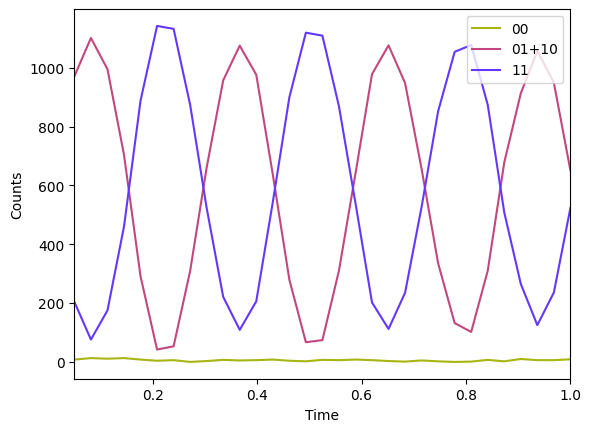

In [29]:
plt.plot(times,counts_00_aquila,label="00",color="#a8b512")
plt.plot(times,counts_01_aquila+counts_10_aquila,label="01+10",color="#C2477F")
plt.plot(times,counts_11_aquila,label="11",color="#6437FF")

plt.plot(times,counts_00_emulate,"k--",label="00")

plt.legend(loc=1)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.axis([min(times),max(times),plt.axis()[2],plt.axis()[3]])